In [0]:

!pip install -q matplotlib-venn

In [0]:
import imageio
#import dicom
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from skimage import morphology
from skimage import measure
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import numpy as np
import scipy.ndimage as ndi 
import os


%matplotlib inline


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import files
uploaded = files.upload()

Saving chest-225.dcm to chest-225.dcm


In [0]:
os.chdir(r"/content/drive/My Drive/Colab Notebooks/tcia-chest-ct-sample/")
path = "/content/drive/My Drive/Colab Notebooks/tcia-chest-ct-sample"

def load_image():
  dcm_list=[]
  for file in os.listdir(path):
    print((file))
    f=str(os.getcwd())+ '/'+str(file)
    dcm_list.append(f)
  return dcm_list

def image_stack(stack):
  cols = len(stack)
  rows = 1
  im_list = []
  for i in range(len(stack)):
    im_list.append(imageio.imread(stack[i]))
  fig, axes = plt.subplots(rows, cols, figsize=[12,12])
  for i in range(len(stack)): 
    axes[i].imshow(im_list[i], cmap='gray')
  plt.show()

chest-220.dcm
chest-222.dcm
chest-224.dcm
chest-221.dcm
chest-225.dcm


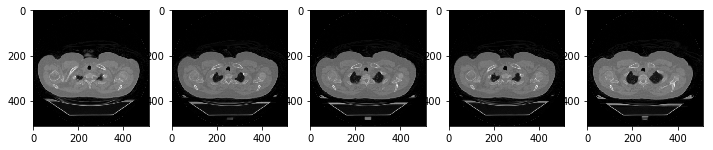

In [0]:
image_stack(load_image())

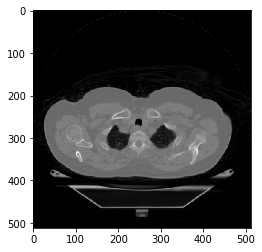

In [0]:
im = imageio.imread('chest-225.dcm')
#fig,plt = plt.subplots()
plt.imshow(im, cmap='gray')
#plt.imshow(im, cmap='gray', vmin=-200, vmax=200)
#fig.savefig('im_')


In [0]:
im.meta


Dict([('TransferSyntaxUID', '1.2.840.10008.1.2'),
      ('SOPClassUID', '1.2.840.10008.5.1.4.1.1.2'),
      ('SOPInstanceUID',
       '1.3.6.1.4.1.14519.5.2.1.5168.1900.290866807370146801046392918286'),
      ('StudyDate', '20040529'),
      ('SeriesDate', '20040515'),
      ('ContentDate', '20040515'),
      ('StudyTime', '115208'),
      ('SeriesTime', '115254'),
      ('ContentTime', '115325'),
      ('Modality', 'CT'),
      ('Manufacturer', 'GE MEDICAL SYSTEMS'),
      ('StudyDescription', 'PET CT with registered MR'),
      ('SeriesDescription', 'CT IMAGES - RESEARCH'),
      ('PatientName', 'STS_007'),
      ('PatientID', 'STS_007'),
      ('PatientBirthDate', ''),
      ('PatientSex', 'F '),
      ('PatientWeight', 82.0),
      ('StudyInstanceUID',
       '1.3.6.1.4.1.14519.5.2.1.5168.1900.381397737790414481604846607090'),
      ('SeriesInstanceUID',
       '1.3.6.1.4.1.14519.5.2.1.5168.1900.315477836840324582280843038439'),
      ('SeriesNumber', 2),
      ('AcquisitionNumber'

StandardScaler(copy=True, with_mean=True, with_std=True)


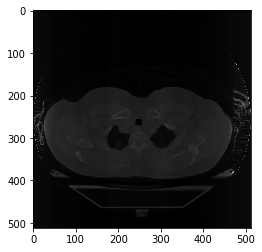

In [0]:
scaler = StandardScaler()
print(scaler.fit(im))
#print(scaler.mean_)
im_ = scaler.fit_transform(im)
plt.imshow(im_, cmap='gray')

[9220.990911466843, 3869.5523260904642, 3320.506857200884, 2958.0909441843414, 2788.407935057556, 2655.8877923824753, 2573.529172122283, 2504.2814730977925, 2402.9572734138746]


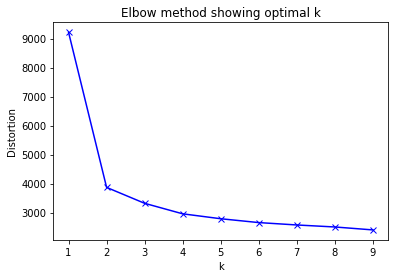

In [0]:
distortions = []
K = range(1,10)

#Determine k
for k in K:
  kmeanModel = KMeans(n_clusters=k).fit(im)
  #sum of squared distances
  distortions.append(sum(np.min(cdist(im, kmeanModel.cluster_centers_, 'euclidean'), axis=1))/im.shape[0])

print(distortions)

# plot elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow method showing optimal k')
plt.show()

In [0]:
im.meta

In [0]:
def make_chestmask(im, display=False):
  row_size = im.shape[0]
  col_size = im.shape[1]
  
  mean = np.mean(im)
  std = np.std(im)
  im = (im-mean)/std
  
  middle = im[int(col_size/5):int(col_size/5*4), int(row_size/5):int(row_size/5*4)]
  
  mean = np.mean(middle)
  max = np.max(im)
  min = np.min(im)
  
  im[im==max]=mean
  im[im==min]=mean
  
  kmeans = KMeans(n_clusters=2).fit(np.reshape(middle, [np.prod(middle.shape),1]))
  centers = sorted(kmeans.cluster_centers_.flatten())
  threshold = np.mean(centers)
  threshold_im = np.where(im<threshold, 1.0,0.0)
  
  
  eroded = morphology.erosion(threshold_im, np.ones([3,3]))
  dilation = morphology.dilation(eroded, np.ones([8,8]))
  
  labels = measure.label(dilation)
  label_vals = np.unique(labels)
  regions = measure.regionprops(labels)
  
  good_labels = []
  for prop in regions:
    B = prop.bbox
    if (B[2]-B[0] <row_size/10*9) and (B[3]-B[1]<col_size/10*9) and (B[0]>row_size/5) and (B[2]<col_size/5*4):
      good_labels.append(prop.label)
      
  mask = np.ndarray([row_size, col_size], dtype = np.int8)
  mask[:] = 0
    
  
  for N in good_labels:
    mask =  mask + np.where(labels==N,1,0)
  
  mask = morphology.dilation(mask,np.ones([10,10]))
  
  if (display):
    fig, ax = plt.subplots(3,2, figsize=[12,12])
    ax[0, 0].set_title('Original Image')
    ax[0, 0].imshow(im, cmap='gray')
    
    ax[0, 1].set_title('Threshold')
    ax[0, 1].imshow(threshold_im, cmap='gray')
    
    ax[1, 0].set_title('After Erosion and Dilation')
    ax[1, 0].imshow(dilation, cmap='gray')
    
    ax[1, 1].set_title('Colour Labels')
    ax[1, 1].imshow(labels)
    
    ax[2, 0].set_title('Final Mask')
    ax[2, 0].imshow(mask, cmap='gray')
    
    ax[2, 1].set_title('Apply Mask')
    ax[2, 1].imshow(mask*im, cmap='gray')
    
    plt.show()
    
  return mask*im

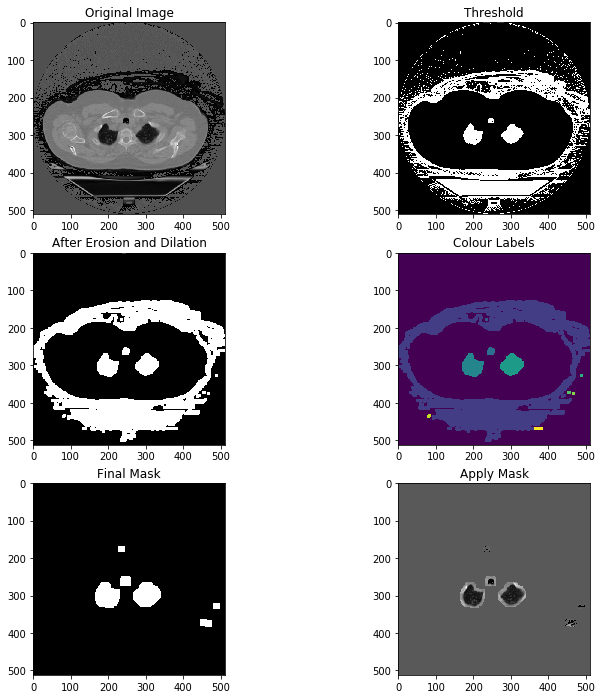

Array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [0]:
make_chestmask(im, display=True)

chest-220.dcm
chest-222.dcm
chest-224.dcm
chest-221.dcm
chest-225.dcm


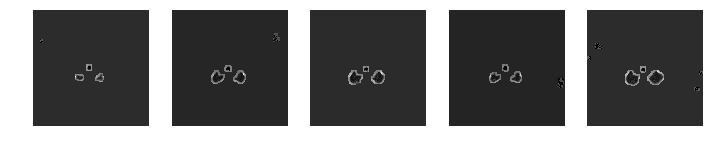

In [0]:
# Segmentation to all slices
im=[]
segmented_image=[]

stack = load_image()
for i in range(len(stack)):
    im.append(imageio.imread(stack[i]))

for i in range(len(stack)):
    segmented_image.append(make_chestmask(im[i]))

rows = 1
cols = len(segmented_image)
fig, ax = plt.subplots(rows, cols, figsize=[12,12]) 
for i in range(rows*cols):
  ax[i].imshow(segmented_image[i], cmap='gray')
  ax[i].axis('off')
plt.show()


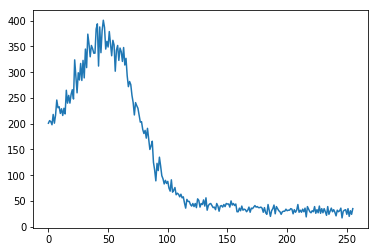

In [0]:
hist = ndi.histogram(im, min=0, max=255, bins=256)
fig, axes = plt.subplots()
axes.plot(hist)